In [2]:
import os 
import sys 
sys.path.append("../")
import argparse

import random
import math
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD, lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.augmentations import get_transform
from data.get_datasets import get_datasets, get_class_splits

import SSB
from SSB.get_datasets.get_gcd_datasets_funcs import get_gcd_datasets
from SSB.utils import load_class_splits

from util.general_utils import AverageMeter, init_experiment
from util.cluster_and_log_utils import log_accs_from_preds
from config import exp_root
from model import DINOHead, info_nce_logits, SupConLoss, DistillLoss, ContrastiveLearningViewGenerator, get_params_groups

random_seed = 777
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
parser = argparse.ArgumentParser(description='cluster', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--num_workers', default=8, type=int)
parser.add_argument('--eval_funcs', nargs='+', help='Which eval functions to use', default=['v2', 'v2p'])

parser.add_argument('--warmup_model_dir', type=str, default=None)
parser.add_argument('--dataset_name', type=str, default='scars', help='options: cifar10, cifar100, imagenet_100, cub, scars, fgvc_aricraft, herbarium_19')
parser.add_argument('--prop_train_labels', type=float, default=0.5)
parser.add_argument('--use_ssb_splits', action='store_true', default=True)

parser.add_argument('--grad_from_block', type=int, default=11)
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--gamma', type=float, default=0.1)
parser.add_argument('--momentum', type=float, default=0.9)
parser.add_argument('--weight_decay', type=float, default=1e-4)
parser.add_argument('--epochs', default=1000, type=int)
parser.add_argument('--exp_root', type=str, default=exp_root)
parser.add_argument('--transform', type=str, default='imagenet')
parser.add_argument('--sup_weight', type=float, default=0.35)
parser.add_argument('--n_views', default=2, type=int)

parser.add_argument('--memax_weight', type=float, default=2)
parser.add_argument('--warmup_teacher_temp', default=0.07, type=float, help='Initial value for the teacher temperature.')
parser.add_argument('--teacher_temp', default=0.04, type=float, help='Final value (after linear warmup)of the teacher temperature.')
parser.add_argument('--warmup_teacher_temp_epochs', default=30, type=int, help='Number of warmup epochs for the teacher temperature.')

parser.add_argument('--fp16', action='store_true', default=False)
parser.add_argument('--print_freq', default=10, type=int)
parser.add_argument('--exp_name', default=None, type=str)

args = parser.parse_args(args=[])
device = torch.device('cpu')

/conor/SimGCD-ICCV-Challenge/SSB/SSB/utils.py:55: UserWarning: The dataset path is set to the default value. Consider setting it to a suitable path in your ~/.ssb/ssb_config.json file.
  warnings.warn("The dataset path is set to the default value. "


In [94]:
args.dataset_name = "aircraft"

In [95]:

# NOTE: Hardcoded image size as we do not finetune the entire ViT model
args.image_size = 224
args.feat_dim = 768
args.num_mlp_layers = 3
# args.mlp_out_dim = args.num_labeled_classes + args.num_unlabeled_classes
# import ipdb; ipdb.set_trace()
class_splits = load_class_splits(args.dataset_name)
args.train_classes = class_splits['known_classes']
args.mlp_out_dim = len(class_splits['known_classes']) \
                 + len(class_splits['unknown_classes']['Easy']) \
                 + len(class_splits['unknown_classes']['Medium']) \
                 + len(class_splits['unknown_classes']['Hard'])
train_transform, test_transform = get_transform(args.transform, image_size=args.image_size, args=args)
train_transform = ContrastiveLearningViewGenerator(base_transform=train_transform, n_views=args.n_views)
# --------------------
# DATASETS
# --------------------
train_dataset, test_dataset, unlabelled_train_examples_test, datasets = get_gcd_datasets(args.dataset_name, 
                                                                                        train_transform,
                                                                                        test_transform,)

# --------------------
# SAMPLER
# Sampler which balances labelled and unlabelled examples in each batch
# --------------------
label_len = len(train_dataset.labelled_dataset)
unlabelled_len = len(train_dataset.unlabelled_dataset)
sample_weights = [1 if i < label_len else label_len / unlabelled_len for i in range(len(train_dataset))]
sample_weights = torch.DoubleTensor(sample_weights)
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(train_dataset))

train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False,
                              sampler=sampler, drop_last=True, pin_memory=True)

In [96]:
classes_trainset = []

for batch in train_loader:
    images, class_labels, uq_idxs, mask_lab = batch
    classes_trainset += list(class_labels.cpu().numpy())

전체 클래스 셋 :  100
train set 의 클래스 셋 :  100


<BarContainer object of 100 artists>

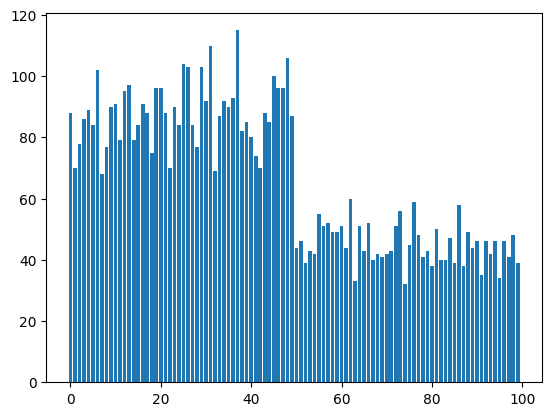

In [87]:
# Aircraft
print("전체 클래스 셋 : ", args.mlp_out_dim)
print("train set 의 클래스 셋 : ", len(np.unique(classes_trainset)))
plt.bar(*np.unique(classes_trainset, return_counts=True))

전체 클래스 셋 :  200
train set 의 클래스 셋 :  200


<BarContainer object of 200 artists>

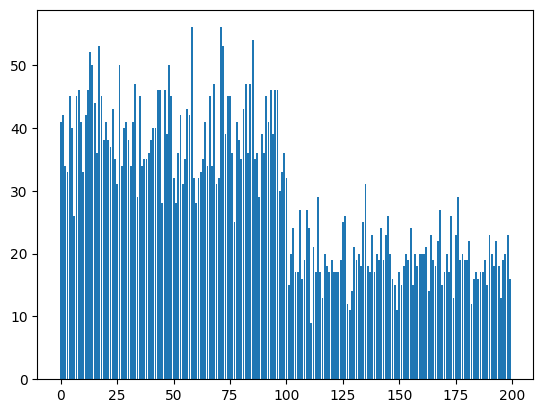

In [97]:
# CUB
print("전체 클래스 셋 : ", args.mlp_out_dim)
print("train set 의 클래스 셋 : ", len(np.unique(classes_trainset)))
plt.bar(*np.unique(classes_trainset, return_counts=True))

전체 클래스 셋 :  196
train set 의 클래스 셋 :  196


<BarContainer object of 196 artists>

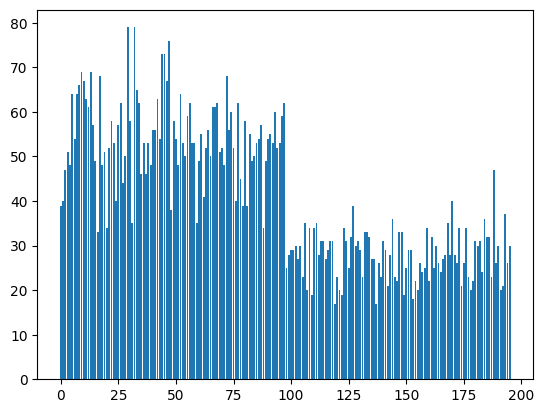

In [92]:
# Stanfords cars
print("전체 클래스 셋 : ", args.mlp_out_dim)
print("train set 의 클래스 셋 : ", len(np.unique(classes_trainset)))
plt.bar(*np.unique(classes_trainset, return_counts=True))

196

In [47]:
images[0].shape, images[1].shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 3, 224, 224]))

In [35]:
import matplotlib.pyplot as plt

x = images[0][0].cpu().numpy()
x_p = images[0][0].cpu().numpy()
x = x.reshape(224, 224, 3)
x_p = x_p.reshape(224, 224, 3)

In [25]:
images[0].shape, images[1].shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 3, 224, 224]))

In [32]:
mask_lab

tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],

In [31]:
uq_idxs

tensor([ 269, 6396,  113,  535, 5873, 7278, 3324,  390, 6575, 1020, 6719, 7296,
        3216, 7877,  828, 7379, 5619,  321, 7617, 6481, 4319, 6811, 1293, 4823,
        7011, 5105, 1742, 4929, 6601, 6631, 6179, 4943, 5760, 5097, 7162, 1867,
        4659,  292, 5938, 6908, 3967, 7159, 6998, 4796, 7692, 1129, 5413, 2390,
        2069, 4062, 1050,  998, 8122, 3787, 4300, 4774, 3437, 5574, 5020, 2060,
        4196, 5195, 7323, 5047, 7157, 6981, 2353, 1299,  137, 5744, 3156, 3347,
        3804,  366, 5660, 6173, 4287, 3622, 2047, 3506, 1823, 4389, 5087,  713,
        4793, 3744, 6662, 7529, 7115, 2462,  329, 5933, 6731, 2631, 1161, 6923,
        5868, 3237, 7492, 8110, 3806,   18, 1270, 6564,   17, 5512, 7327, 4239,
        5412, 4787, 7736, 7048, 1724, 4128,  807, 7668, 1722,  104, 7868, 6821,
        3996, 5613,  164,  547, 7049, 4133, 7221, 7095])

In [30]:
class_labels.cpu().numpy()

array([122,  28,   0, 123,  51,  37, 166,  78,  61, 126,  32,  68, 169,
        73, 128,  89,  14,  77, 119,  58,  48,  31, 133, 183,  36,  49,
         3, 188,  61,  29,  22, 188,  13,  49,  66, 112, 185,  77,  53,
        63, 172,  66,  36, 179,  72,  82,  50, 113,   5,  86,  81, 126,
        75,  94,  48, 179,  93, 193,  11,   5, 116,  12,  68, 189,  66,
        36, 146, 133,  76,  13,   7,  46, 173, 106,  18,  22,  48,  85,
         5, 177,  83, 182,  49,  91, 179, 101,  30,  70,  65, 160,  77,
        53,  32, 162, 111,  64,  51, 169,  39,  75, 173,  45,   2,  60,
        45,  19,  68,   9,  50, 179,  41,  34,  92,  87, 109,  71,  92,
         0,  73,  31, 172,  14,  76, 123,  34,  87,  67,  65])

In [10]:
args.mlp_out_dim

196

In [9]:
len(train_dataset)

8144

#### Model spec

In [4]:
args.interpolation = 3
args.crop_pct = 0.875

backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
# backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')
        # protobuf                 4.24.2 =>  3.20.0
# backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')# https://github.com/facebookresearch/dinov2/blob/main/MODEL_CARD.md

if args.warmup_model_dir is not None:
    args.logger.info(f'Loading weights from {args.warmup_model_dir}')
    backbone.load_state_dict(torch.load(args.warmup_model_dir, map_location='cpu'))

# NOTE: Hardcoded image size as we do not finetune the entire ViT model
args.image_size = 224
args.feat_dim = 768
args.num_mlp_layers = 3
# args.mlp_out_dim = args.num_labeled_classes + args.num_unlabeled_classes
# import ipdb; ipdb.set_trace()
class_splits = load_class_splits(args.dataset_name)
args.train_classes = class_splits['known_classes']
args.mlp_out_dim = len(class_splits['known_classes']) \
                 + len(class_splits['unknown_classes']['Easy']) \
                 + len(class_splits['unknown_classes']['Medium']) \
                 + len(class_splits['unknown_classes']['Hard'])

# ----------------------
# HOW MUCH OF BASE MODEL TO FINETUNE

# ----------------------
for m in backbone.parameters():
    m.requires_grad = False

# Only finetune layers from block 'args.grad_from_block' onwards
for name, m in backbone.named_parameters():
    if 'block' in name:
        block_num = int(name.split('.')[1])
        if block_num >= args.grad_from_block: #gardient from block 보다 노드가 많으면 학습해야 한단 거가? 
            m.requires_grad = True


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
